# Half-Space LSH Attention with BitNet

This notebook demonstrates:
1. How to use BitNet for text generation
2. How FlexAttention enables custom LSH attention patterns
3. How to integrate LSH attention into BitNet
4. Comparison of results with and without LSH attention


## Setup and Imports

**Important Notes:**
- **accelerate package**: BitNet models require the `accelerate` package. Install with: `pip install accelerate`
- **⚠️ If you get an "accelerate not found" error**: **Restart the Jupyter kernel** (Kernel → Restart) and re-run all cells. This is required because `transformers` checks for `accelerate` at import time.
- To install all requirements: `pip install -r requirements.txt`


In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# CRITICAL: Import accelerate BEFORE transformers
# Transformers checks for accelerate at import time, so it must be imported first
import accelerate
print(f"✓ accelerate version: {accelerate.__version__}")

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from torch.nn.attention.flex_attention import flex_attention
import numpy as np
from typing import Optional
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")

# Use CPU for BitNet (works best on CPU)
device = torch.device("cpu")
print(f"Using device: {device}")


/Users/yuvalshemla/Desktop/sparse-attention/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ accelerate version: 1.12.0
PyTorch version: 2.9.1
Using device: cpu


## Part 1: Simple BitNet Call

Let's start by loading BitNet and making a simple generation call to see how it works.


In [2]:
# Set up model paths
script_dir = os.path.dirname(os.path.abspath('.'))
models_cache_dir = os.path.join(script_dir, "models")
model_id = "microsoft/bitnet-b1.58-2B-4T"

print(f"Model will be loaded from: {models_cache_dir}")


Model will be loaded from: /Users/yuvalshemla/Desktop/models


In [3]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_id, cache_dir=models_cache_dir)

if device.type == "mps":
    model_dtype = torch.float16
else:
    model_dtype = torch.bfloat16

print(f"Loading model with dtype: {model_dtype}...")
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    dtype=model_dtype,
    cache_dir=models_cache_dir
)

# Move model to device
model = model.to(device)
print(f"✓ Model loaded and moved to device: {device}")
print(f"Model config: {model.config.model_type}")
print(f"Hidden size: {model.config.hidden_size}")
print(f"Number of attention heads: {model.config.num_attention_heads}")


You don't have a GPU available to load the model, the inference will be slow because of weight unpacking


Loading model with dtype: torch.bfloat16...
✓ Model loaded and moved to device: cpu
Model config: bitnet
Hidden size: 2560
Number of attention heads: 20


In [4]:
# Simple generation example
prompt = "The future of AI is"
print(f"Prompt: {prompt}")
print("\nGenerating response...")

inputs = tokenizer(prompt, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model.generate(
        inputs.input_ids,
        max_new_tokens=50,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        pad_token_id=tokenizer.eos_token_id
    )

response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"\nResponse: {response}")


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Prompt: The future of AI is

Generating response...

Response: The future of AI is not just about creating machines that can think like humans but also about creating machines that can understand the world in a more holistic way. This means that AI will have to be able to process and analyze large amounts of data, understand natural language, and interact


## Part 2: FlexAttention with Custom LSH Functions

Now let's understand how FlexAttention works and implement the simplest half-space LSH example.


### LSH Oracle: Modular Design

Before implementing the half-space LSH, let's create a clean, extensible architecture. The LSH Oracle will:
1. **Pre-compute key signatures** once (for all keys)
2. **Provide a query interface** to determine which keys to attend to
3. **Be easily extensible** for testing different LSH methods

This design separates the LSH logic from the attention mechanism, making it easy to experiment with different approaches.


In [5]:
class LSHOracle(torch.nn.Module):
    """
    Base class for LSH attention oracles.
    
    An LSH oracle pre-computes signatures for all keys and provides
    a query interface to determine which keys should be attended to.
    
    This design allows easy experimentation with different LSH methods.
    """
    
    def __init__(self, num_heads: int, head_dim: int):
        """
        Args:
            num_heads: Number of attention heads
            head_dim: Dimension of each head
        """
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.key_signatures = None  # Will be set by compute_key_signatures
    
    def compute_key_signatures(self, keys: torch.Tensor, hyperplane_w: torch.Tensor):
        """
        Pre-compute LSH signatures for all keys.
        
        This is called once per forward pass with all keys.
        
        Args:
            keys: Key tensor [batch, num_heads, seq_len, head_dim]
            hyperplane_w: Hyperplane vectors [num_heads, head_dim]
            
        Returns:
            key_signatures: Pre-computed signatures (format depends on implementation)
        """
        raise NotImplementedError("Subclasses must implement compute_key_signatures")
    
    def should_attend(self, batch: int, head: int, q_idx: int, k_idx: int) -> bool:
        """
        Determine if a query should attend to a key.
        
        Args:
            batch: Batch index
            head: Head index
            q_idx: Query position index
            k_idx: Key position index
            
        Returns:
            True if query should attend to key, False otherwise
        """
        raise NotImplementedError("Subclasses must implement should_attend")
    
    def create_score_mod(self, query_signatures: torch.Tensor, key_signatures: torch.Tensor):
        """
        Create a score_mod function for FlexAttention.
        
        This is a convenience method that wraps should_attend for use with FlexAttention.
        
        Args:
            query_signatures: Query signatures [batch, num_heads, seq_len_q]
            key_signatures: Key signatures [batch, num_heads, seq_len_k]
            
        Returns:
            score_mod function compatible with FlexAttention
        """
        # Store signatures for lookups
        self.query_signatures = query_signatures
        self.key_signatures = key_signatures
        
        def score_mod(score, batch, head, q_idx, k_idx):
            # Use should_attend to determine masking
            if self.should_attend(batch, head, q_idx, k_idx):
                return score
            else:
                return torch.tensor(float('-inf'), device=score.device, dtype=score.dtype)
        
        return score_mod


class HalfSpaceLSHOracle(LSHOracle):
    """
    Half-space LSH oracle.
    
    Uses a single random hyperplane per head. Queries attend to keys
    in the same half-space (same sign of dot product with hyperplane).
    """
    
    def __init__(self, num_heads: int, head_dim: int, hyperplane_w: torch.Tensor = None):
        """
        Args:
            num_heads: Number of attention heads
            head_dim: Dimension of each head
            hyperplane_w: Hyperplane vectors [num_heads, head_dim]. If None, random.
        """
        super().__init__(num_heads, head_dim)
        
        if hyperplane_w is None:
            # Initialize random hyperplanes (will be moved to device when module is moved)
            hyperplane_w = torch.randn(num_heads, head_dim)
            hyperplane_w = hyperplane_w / (hyperplane_w.norm(dim=-1, keepdim=True) + 1e-8)
        
        self.register_buffer('hyperplane_w', hyperplane_w)
    
    def compute_key_signatures(self, keys: torch.Tensor, hyperplane_w: torch.Tensor = None):
        """
        Compute half-space signatures for all keys.
        
        Args:
            keys: Key tensor [batch, num_heads, seq_len, head_dim]
            hyperplane_w: Hyperplane vectors [num_heads, head_dim]. If None, use self.hyperplane_w
            
        Returns:
            key_signs: Key signatures [batch, num_heads, seq_len] with values -1, 0, or 1
        """
        if hyperplane_w is None:
            hyperplane_w = self.hyperplane_w
        
        # Compute dot products: [batch, num_heads, seq_len]
        key_dots = torch.einsum('bhsf,hf->bhs', keys, hyperplane_w)
        # Get signs: -1, 0, or 1
        key_signs = torch.sign(key_dots).detach()
        
        self.key_signatures = key_signs
        return key_signs
    
    def compute_query_signatures(self, queries: torch.Tensor, hyperplane_w: torch.Tensor = None):
        """
        Compute half-space signatures for all queries.
        
        Args:
            queries: Query tensor [batch, num_heads, seq_len, head_dim]
            hyperplane_w: Hyperplane vectors [num_heads, head_dim]. If None, use self.hyperplane_w
            
        Returns:
            query_signs: Query signatures [batch, num_heads, seq_len] with values -1, 0, or 1
        """
        if hyperplane_w is None:
            hyperplane_w = self.hyperplane_w
        
        # Compute dot products: [batch, num_heads, seq_len]
        query_dots = torch.einsum('bhlf,hf->bhl', queries, hyperplane_w)
        # Get signs: -1, 0, or 1
        query_signs = torch.sign(query_dots).detach()
        
        # Store for should_attend method
        self.query_signatures = query_signs
        return query_signs
    
    def should_attend(self, batch: int, head: int, q_idx: int, k_idx: int) -> bool:
        """
        Check if query and key are in the same half-space.
        
        Args:
            batch: Batch index
            head: Head index
            q_idx: Query position index
            k_idx: Key position index
            
        Returns:
            True if signs match (same half-space), False otherwise
        """
        if self.query_signatures is None or self.key_signatures is None:
            raise ValueError("Must call compute_key_signatures and set query_signatures first")
        
        q_sign = self.query_signatures[batch, head, q_idx]
        k_sign = self.key_signatures[batch, head, k_idx]
        
        # Signs match if their product is positive
        return (q_sign * k_sign > 0.5).item()
    
    def create_score_mod(self, query_signatures: torch.Tensor, key_signatures: torch.Tensor):
        """
        Create score_mod function for FlexAttention (optimized version).
        
        This version directly uses the pre-computed signatures without calling should_attend
        for better performance.
        """
        def score_mod(score, batch, head, q_idx, k_idx):
            q_sign = query_signatures[batch, head, q_idx]
            k_sign = key_signatures[batch, head, k_idx]
            sign_match = (q_sign * k_sign > 0.5).float()
            
            return torch.where(
                sign_match > 0.5,
                score,
                torch.tensor(float('-inf'), device=score.device, dtype=score.dtype)
            )
        
        return score_mod

print("✓ Created LSHOracle base class and HalfSpaceLSHOracle implementation")


✓ Created LSHOracle base class and HalfSpaceLSHOracle implementation


### Using the LSH Oracle

Now let's use the oracle to implement half-space LSH attention. Notice how clean and modular this is!


In [6]:
# Step 1: Create the LSH oracle
# First, define the parameters for our simple example
batch_size = 1
num_heads = 2
seq_len = 8
head_dim = 16

oracle = HalfSpaceLSHOracle(num_heads=num_heads, head_dim=head_dim)

# The oracle has hyperplane vectors initialized
print(f"Oracle hyperplane shape: {oracle.hyperplane_w.shape}")
print(f"Hyperplane (head 0): {oracle.hyperplane_w[0, :5].numpy()}")


Oracle hyperplane shape: torch.Size([2, 16])
Hyperplane (head 0): [-0.23390657  0.17189293 -0.13955499  0.43347573  0.3144951 ]


In [7]:
# Step 2: Pre-compute key signatures (done once for all keys)
# First, create Q, K, V tensors for the example
Q = torch.randn(batch_size, num_heads, seq_len, head_dim)
K = torch.randn(batch_size, num_heads, seq_len, head_dim)
V = torch.randn(batch_size, num_heads, seq_len, head_dim)

# Now compute key signatures
key_signatures = oracle.compute_key_signatures(K, oracle.hyperplane_w)
print(f"Key signatures shape: {key_signatures.shape}")
print(f"Key signatures (head 0): {key_signatures[0, 0].numpy()}")
print(f"Unique values: {torch.unique(key_signatures).numpy()}")


Key signatures shape: torch.Size([1, 2, 8])
Key signatures (head 0): [ 1.  1.  1. -1.  1. -1. -1.  1.]
Unique values: [-1.  1.]


In [8]:
# Step 3: Compute query signatures (done once for all queries)
query_signatures = oracle.compute_query_signatures(Q, oracle.hyperplane_w)
print(f"Query signatures shape: {query_signatures.shape}")
print(f"Query signatures (head 0): {query_signatures[0, 0].numpy()}")


Query signatures shape: torch.Size([1, 2, 8])
Query signatures (head 0): [ 1. -1. -1. -1.  1. -1.  1. -1.]


In [9]:
# Step 4: Create score_mod function using the oracle

lsh_score_mod = oracle.create_score_mod(query_signatures, key_signatures)
print("✓ Created LSH score_mod function using oracle")

# Test the oracle's should_attend method
# The signatures are now stored in the oracle from compute_key_signatures and compute_query_signatures
print(f"\nTesting should_attend:")
print(f"  Query 0, Key 0: {oracle.should_attend(0, 0, 0, 0)}")
print(f"  Query 0, Key 1: {oracle.should_attend(0, 0, 0, 1)}")
print(f"  Query 1, Key 0: {oracle.should_attend(0, 0, 1, 0)}")


✓ Created LSH score_mod function using oracle

Testing should_attend:
  Query 0, Key 0: True
  Query 0, Key 1: True
  Query 1, Key 0: False


### Half-Space LSH: The Simplest Example

**Concept**: 
1. Sample a random hyperplane vector `w`
2. For each query `q`, compute `sign(dot(w, q))`
3. For each key `k`, compute `sign(dot(w, k))`
4. Only allow attention if signs match (same half-space)

This creates a sparse attention pattern where queries only attend to "similar" keys (in the same half-space).


In [10]:
# Step 1: Sample a random hyperplane vector
hyperplane_w = torch.randn(num_heads, head_dim)
# Normalize it
hyperplane_w = hyperplane_w / (hyperplane_w.norm(dim=-1, keepdim=True) + 1e-8)
print(f"Hyperplane shape: {hyperplane_w.shape}")
print(f"Hyperplane (head 0): {hyperplane_w[0, :5].numpy()}")


Hyperplane shape: torch.Size([2, 16])
Hyperplane (head 0): [-0.44362113 -0.0333774   0.36112836  0.33516774  0.0362303 ]


In [11]:
# Step 2: Compute signs for queries and keys
# For each query: sign(dot(w, q))
query_dots = torch.einsum('bhlf,hf->bhl', Q, hyperplane_w)
query_signs = torch.sign(query_dots).detach()  # Detach to avoid gradient issues

# For each key: sign(dot(w, k))
key_dots = torch.einsum('bhsf,hf->bhs', K, hyperplane_w)
key_signs = torch.sign(key_dots).detach()

print(f"Query signs shape: {query_signs.shape}")
print(f"Query signs (head 0): {query_signs[0, 0].numpy()}")
print(f"Key signs (head 0): {key_signs[0, 0].numpy()}")


Query signs shape: torch.Size([1, 2, 8])
Query signs (head 0): [ 1. -1.  1.  1.  1. -1.  1.  1.]
Key signs (head 0): [ 1. -1.  1. -1. -1.  1.  1.  1.]


In [12]:
# Step 3: Create score_mod function that masks mismatched signs
def create_lsh_score_mod(query_signs, key_signs):
    """
    Creates a score_mod function for half-space LSH attention.
    
    If query and key are in the same half-space (signs match),
    return the original score. Otherwise, return -inf (masked).
    """
    def score_mod(score, batch, head, q_idx, k_idx):
        # Look up the signs for this (query, key) pair
        q_sign = query_signs[batch, head, q_idx]
        k_sign = key_signs[batch, head, k_idx]
        
        # Check if signs match (same half-space)
        # sign_match = 1 if q_sign * k_sign > 0, else 0
        sign_match = (q_sign * k_sign > 0.5).float()
        
        # If signs match, return original score; otherwise mask with -inf
        return torch.where(
            sign_match > 0.5,
            score,
            torch.tensor(float('-inf'), device=score.device, dtype=score.dtype)
        )
    
    return score_mod

# Create the score_mod function
lsh_score_mod = create_lsh_score_mod(query_signs, key_signs)
print("✓ Created LSH score_mod function")


✓ Created LSH score_mod function


In [13]:
# Step 4: Apply FlexAttention with LSH masking (using oracle)
# Note: You may see a warning about torch.compile() - this is normal for debugging.
# For production, you can use: torch.compile(flex_attention)(...) for better performance.

# First, compute standard attention for comparison
output_standard = flex_attention(Q, K, V, scale=1.0 / (head_dim ** 0.5))
print(f"Standard attention output shape: {output_standard.shape}")
print(f"Standard attention norm: {output_standard.norm().item():.4f}")

# Now compute LSH attention
output_lsh = flex_attention(
    Q, K, V,
    score_mod=lsh_score_mod,
    scale=1.0 / (head_dim ** 0.5)
)

print(f"\nLSH attention output shape: {output_lsh.shape}")
print(f"LSH attention norm: {output_lsh.norm().item():.4f}")

# Compare with standard attention
diff = (output_standard - output_lsh).abs().mean()
print(f"\nMean absolute difference from standard attention: {diff.item():.4f}")


Standard attention output shape: torch.Size([1, 2, 8, 16])
Standard attention norm: 6.8566

LSH attention output shape: torch.Size([1, 2, 8, 16])
LSH attention norm: 8.4556

Mean absolute difference from standard attention: 0.1947


/Users/yuvalshemla/Desktop/sparse-attention/.venv/lib/python3.13/site-packages/torch/nn/attention/flex_attention.py:1687: UserWarning: flex_attention called without torch.compile() - this will use an unfused implementation that materializes the full scores matrix instead of generating a fused kernel.

SOLUTION: Use torch.compile(flex_attention)(...)

If you want to debug your score_mod/mask_mod, you can set:
torch.nn.attention.flex_attention._FLEX_ATTENTION_DISABLE_COMPILE_DEBUG = True

This will allow you to use print statements or breakpoints. Note: This doesn't work with the backwards pass and may produce incorrect results.
  _warn_once(


### Example: Easy Extension for Testing Other LSH Methods

The oracle design makes it trivial to test different LSH approaches. Here's an example of how you could add a multi-hyperplane LSH:


In [14]:
class MultiHyperplaneLSHOracle(LSHOracle):
    """
    Example: Multi-hyperplane LSH oracle.
    
    Uses multiple hyperplanes per head. A query attends to a key
    if they match on at least k hyperplanes.
    
    This demonstrates how easy it is to extend the oracle design!
    """
    
    def __init__(self, num_heads: int, head_dim: int, num_hyperplanes: int = 2, min_matches: int = 1):
        super().__init__(num_heads, head_dim)
        self.num_hyperplanes = num_hyperplanes
        self.min_matches = min_matches
        
        # Initialize multiple hyperplanes per head
        # Will be moved to device when module is moved via .to(device)
        hyperplanes = torch.randn(num_heads, num_hyperplanes, head_dim)
        hyperplanes = hyperplanes / (hyperplanes.norm(dim=-1, keepdim=True) + 1e-8)
        self.register_buffer('hyperplanes', hyperplanes)
    
    def compute_key_signatures(self, keys: torch.Tensor, hyperplanes: torch.Tensor = None):
        if hyperplanes is None:
            hyperplanes = self.hyperplanes
        
        # Compute signs for each hyperplane: [batch, num_heads, num_hyperplanes, seq_len]
        key_dots = torch.einsum('bhsf,hnf->bhns', keys, hyperplanes)
        key_signs = torch.sign(key_dots).detach()
        
        self.key_signatures = key_signs
        return key_signs
    
    def compute_query_signatures(self, queries: torch.Tensor, hyperplanes: torch.Tensor = None):
        if hyperplanes is None:
            hyperplanes = self.hyperplanes
        
        # Compute signs for each hyperplane: [batch, num_heads, num_hyperplanes, seq_len]
        query_dots = torch.einsum('bhlf,hnf->bhnl', queries, hyperplanes)
        query_signs = torch.sign(query_dots).detach()
        
        return query_signs
    
    def should_attend(self, batch: int, head: int, q_idx: int, k_idx: int) -> bool:
        if self.query_signatures is None or self.key_signatures is None:
            raise ValueError("Must compute signatures first")
        
        # Check how many hyperplanes match
        q_signs = self.query_signatures[batch, head, :, q_idx]  # [num_hyperplanes]
        k_signs = self.key_signatures[batch, head, :, k_idx]    # [num_hyperplanes]
        
        matches = (q_signs * k_signs > 0.5).sum().item()
        return matches >= self.min_matches
    
    def create_score_mod(self, query_signatures: torch.Tensor, key_signatures: torch.Tensor):
        def score_mod(score, batch, head, q_idx, k_idx):
            q_signs = query_signatures[batch, head, :, q_idx]
            k_signs = key_signatures[batch, head, :, k_idx]
            matches = (q_signs * k_signs > 0.5).sum()
            
            if matches >= self.min_matches:
                return score
            else:
                return torch.tensor(float('-inf'), device=score.device, dtype=score.dtype)
        
        return score_mod

print("✓ Example: MultiHyperplaneLSHOracle class created")
print("  This shows how easy it is to extend the oracle for different LSH methods!")
print("  To use it, just replace HalfSpaceLSHOracle with MultiHyperplaneLSHOracle")


✓ Example: MultiHyperplaneLSHOracle class created
  This shows how easy it is to extend the oracle for different LSH methods!
  To use it, just replace HalfSpaceLSHOracle with MultiHyperplaneLSHOracle


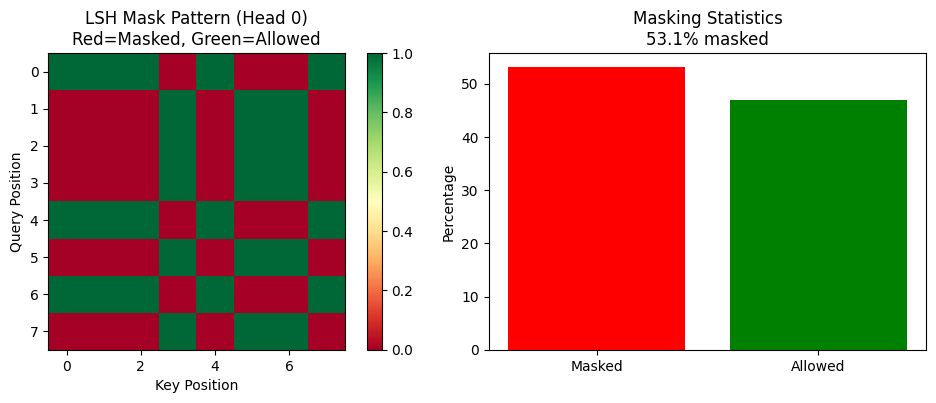


Masking ratio: 53.1%
Expected: ~50% (random hyperplane splits space in half)


In [15]:
# Visualize the masking pattern

import matplotlib.pyplot as plt

# Compute which pairs are masked (for visualization)
sign_match_matrix = (query_signatures.unsqueeze(-1) * key_signatures.unsqueeze(-2) > 0.5).float()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sign_match_matrix[0, 0].cpu().numpy(), cmap='RdYlGn', vmin=0, vmax=1)
plt.title(f"LSH Mask Pattern (Head 0)\nRed=Masked, Green=Allowed")
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.colorbar()

plt.subplot(1, 2, 2)
masking_ratio = (1 - sign_match_matrix.mean()).item() * 100
plt.bar(['Masked', 'Allowed'], 
        [masking_ratio, 100 - masking_ratio], 
        color=['red', 'green'])
plt.title(f"Masking Statistics\n{masking_ratio:.1f}% masked")
plt.ylabel("Percentage")

plt.tight_layout()
plt.show()

print(f"\nMasking ratio: {masking_ratio:.1f}%")
print(f"Expected: ~50% (random hyperplane splits space in half)")

### Understanding FlexAttention

FlexAttention allows us to modify attention scores element-wise using a `score_mod` function:

```python
def score_mod(score, batch, head, q_idx, k_idx) -> Tensor:
    # Modify the attention score here
    return modified_score
```

This function receives:
- `score`: The computed attention score (scalar)
- `batch`, `head`, `q_idx`, `k_idx`: Indices for the current position

We can use this to implement custom attention patterns like LSH!


In [16]:
# Simple example: Standard attention with FlexAttention
# Note: batch_size, num_heads, seq_len, head_dim are already defined earlier

# Create random Q, K, V
Q = torch.randn(batch_size, num_heads, seq_len, head_dim)
K = torch.randn(batch_size, num_heads, seq_len, head_dim)
V = torch.randn(batch_size, num_heads, seq_len, head_dim)

print(f"Q shape: {Q.shape}")
print(f"K shape: {K.shape}")
print(f"V shape: {V.shape}")


Q shape: torch.Size([1, 2, 8, 16])
K shape: torch.Size([1, 2, 8, 16])
V shape: torch.Size([1, 2, 8, 16])


In [17]:
# Standard attention (no score_mod)
output_standard = flex_attention(Q, K, V, scale=1.0 / (head_dim ** 0.5))
print(f"Standard attention output shape: {output_standard.shape}")
print(f"Output norm: {output_standard.norm().item():.4f}")


Standard attention output shape: torch.Size([1, 2, 8, 16])
Output norm: 6.3493


## Part 3: What We Need to Change in BitNet

To integrate LSH attention into BitNet, we need to:

1. **Inspect the model structure** to find where attention is implemented
2. **Identify the attention module** (likely `self_attn` or `attn` in each layer)
3. **Create an LSH attention wrapper** that matches the interface
4. **Replace the attention computation** in the forward pass

Let's inspect BitNet's structure:


In [18]:
# Inspect BitNet's structure
print("Model type:", type(model).__name__)
print("\nModel attributes:")
for attr in dir(model):
    if not attr.startswith('_'):
        obj = getattr(model, attr)
        if not callable(obj):
            print(f"  {attr}: {type(obj).__name__}")


Model type: BitNetForCausalLM

Model attributes:
  T_destination: TypeVar
  base_model_prefix: str
  call_super_init: bool
  can_record_outputs: dict
  config: BitNetConfig
  device: device
  dtype: dtype
  dummy_inputs: dict
  dump_patches: bool
  framework: str
  generation_config: GenerationConfig
  hf_quantizer: BitNetHfQuantizer
  is_gradient_checkpointing: bool
  is_parallelizable: bool
  is_quantized: bool
  loss_type: str
  main_input_name: str
  model_tags: NoneType
  name_or_path: str
  pp_plan: dict
  quantization_method: QuantizationMethod
  supports_gradient_checkpointing: bool
  supports_pp_plan: bool
  supports_tp_plan: bool
  tp_plan: dict
  tp_size: NoneType
  training: bool
  use_kernels: bool
  vocab_size: int
  warnings_issued: dict


In [19]:
# Find the transformer layers
if hasattr(model, 'model') and hasattr(model.model, 'layers'):
    layers = model.model.layers
    print(f"Found layers at: model.model.layers")
    print(f"Number of layers: {len(layers)}")
elif hasattr(model, 'transformer') and hasattr(model.transformer, 'h'):
    layers = model.transformer.h
    print(f"Found layers at: model.transformer.h")
    print(f"Number of layers: {len(layers)}")
else:
    print("Searching for layers...")
    for name, module in model.named_modules():
        if 'layer' in name.lower() and isinstance(module, torch.nn.ModuleList):
            layers = module
            print(f"Found layers at: {name}")
            print(f"Number of layers: {len(layers)}")
            break


Found layers at: model.model.layers
Number of layers: 30


In [20]:
# Inspect the first layer to understand its structure
first_layer = layers[0]
print("First layer type:", type(first_layer).__name__)
print("\nFirst layer attributes (all):")
for attr in dir(first_layer):
    if not attr.startswith('_'):
        try:
            obj = getattr(first_layer, attr)
            if isinstance(obj, torch.nn.Module):
                print(f"  {attr}: {type(obj).__name__}")
            elif not callable(obj):
                print(f"  {attr}: {type(obj).__name__} = {obj}")
        except:
            pass

# Also try using named_modules for a cleaner view
print("\nFirst layer modules (using named_modules):")
for name, module in first_layer.named_modules():
    if name:  # Skip the root module itself
        print(f"  {name}: {type(module).__name__}")


First layer type: BitNetDecoderLayer

First layer attributes (all):
  T_destination: TypeVar = ~T_destination
  call_super_init: bool = False
  dump_patches: bool = False
  gradient_checkpointing: bool = False
  hidden_size: int = 2560
  input_layernorm: BitNetRMSNorm
  mlp: BitNetMLP
  post_attention_layernorm: BitNetRMSNorm
  self_attn: BitNetAttention
  training: bool = False

First layer modules (using named_modules):
  self_attn: BitNetAttention
  self_attn.q_proj: AutoBitLinear
  self_attn.k_proj: AutoBitLinear
  self_attn.v_proj: AutoBitLinear
  self_attn.o_proj: AutoBitLinear
  self_attn.attn_sub_norm: BitNetRMSNorm
  mlp: BitNetMLP
  mlp.gate_proj: AutoBitLinear
  mlp.up_proj: AutoBitLinear
  mlp.down_proj: AutoBitLinear
  mlp.act_fn: ReLUSquaredActivation
  mlp.ffn_sub_norm: BitNetRMSNorm
  input_layernorm: BitNetRMSNorm
  post_attention_layernorm: BitNetRMSNorm


In [21]:
# Find the attention module
if hasattr(first_layer, 'self_attn'):
    attn_module = first_layer.self_attn
    attn_name = 'self_attn'
    print(f"Found attention at: self_attn")
elif hasattr(first_layer, 'attn'):
    attn_module = first_layer.attn
    attn_name = 'attn'
    print(f"Found attention at: attn")
else:
    print("Could not find attention module. Available attributes:")
    for attr in dir(first_layer):
        if 'attn' in attr.lower():
            print(f"  {attr}")

print(f"\nAttention module type: {type(attn_module).__name__}")
print(f"Attention module: {attn_module}")


Found attention at: self_attn

Attention module type: BitNetAttention
Attention module: BitNetAttention(
  (q_proj): AutoBitLinear(in_features=2560, out_features=2560, bias=False)
  (k_proj): AutoBitLinear(in_features=2560, out_features=640, bias=False)
  (v_proj): AutoBitLinear(in_features=2560, out_features=640, bias=False)
  (o_proj): AutoBitLinear(in_features=2560, out_features=2560, bias=False)
  (attn_sub_norm): BitNetRMSNorm((2560,), eps=1e-05)
)


In [22]:
# Check the attention module's forward signature
import inspect
if hasattr(attn_module, 'forward'):
    sig = inspect.signature(attn_module.forward)
    print("Attention forward signature:")
    print(sig)
    
    # Try to see what it expects
    print("\nChecking forward method source...")
    try:
        source = inspect.getsource(attn_module.forward)
        print("First few lines:")
        print('\n'.join(source.split('\n')[:10]))
    except:
        print("Could not get source")


Attention forward signature:
(hidden_states: torch.Tensor, position_embeddings: tuple[torch.Tensor, torch.Tensor], attention_mask: Optional[torch.Tensor], past_key_values: Optional[transformers.cache_utils.Cache] = None, cache_position: Optional[torch.LongTensor] = None, **kwargs: Unpack[transformers.modeling_flash_attention_utils.FlashAttentionKwargs]) -> tuple[torch.Tensor, typing.Optional[torch.Tensor]]

Checking forward method source...
First few lines:
    @deprecate_kwarg("past_key_value", new_name="past_key_values", version="4.58")
    def forward(
        self,
        hidden_states: torch.Tensor,
        position_embeddings: tuple[torch.Tensor, torch.Tensor],
        attention_mask: Optional[torch.Tensor],
        past_key_values: Optional[Cache] = None,
        cache_position: Optional[torch.LongTensor] = None,
        **kwargs: Unpack[FlashAttentionKwargs],
    ) -> tuple[torch.Tensor, Optional[torch.Tensor]]:


### Creating an LSH Attention Wrapper

We need to create a wrapper that:
1. Has the same interface as BitNet's attention module
2. Uses FlexAttention with LSH masking internally
3. Handles Q/K/V projections correctly


In [23]:
class LSHAttentionWrapper(torch.nn.Module):
    """
    Wrapper that replaces standard attention with LSH attention using an LSH Oracle.
    
    This wrapper uses the modular oracle design, making it easy to swap
    different LSH methods by changing the oracle.
    """
    def __init__(self, original_attn, embed_dim, num_heads, head_dim=None, oracle=None):
        super().__init__()
        self.original_attn = original_attn
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = head_dim if head_dim is not None else embed_dim // num_heads
        
        # Use provided oracle or create default half-space oracle
        if oracle is None:
            self.oracle = HalfSpaceLSHOracle(num_heads, self.head_dim)
        else:
            self.oracle = oracle
        
        # Note: Oracle will be moved to device when wrapper is moved via .to(device)
        
        # Copy Q/K/V projections from original attention if they exist
        if hasattr(original_attn, 'q_proj'):
            self.q_proj = original_attn.q_proj
            self.k_proj = original_attn.k_proj
            self.v_proj = original_attn.v_proj
            self.o_proj = original_attn.o_proj if hasattr(original_attn, 'o_proj') else None
        else:
            # If structure is different, we'll need to adapt
            self.q_proj = None
    
    def forward(self, hidden_states, *args, **kwargs):
        """
        Forward pass with LSH attention using the oracle.
        
        The oracle pre-computes key signatures once, then determines
        which keys each query should attend to.
        """
        # Get Q, K, V from the original attention module's projections
        if self.q_proj is None:
            # Fallback to original attention if we can't intercept
            return self.original_attn(hidden_states, *args, **kwargs)
        
        batch_size, seq_len, _ = hidden_states.shape
        
        # Project to Q, K, V
        Q = self.q_proj(hidden_states)
        K = self.k_proj(hidden_states)
        V = self.v_proj(hidden_states)
        
        # BitNet uses quantized/1.58-bit projections which may output different shapes
        # Check if we can reshape to expected format
        expected_total = batch_size * seq_len * self.num_heads * self.head_dim
        actual_total = Q.numel()
        
        if actual_total != expected_total:
            # BitNet's projection format doesn't match - fall back to original
            # This happens because BitNet uses specialized quantized layers
            return self.original_attn(hidden_states, *args, **kwargs)
        
        # Reshape to [B, H, L, head_dim] format for FlexAttention
        try:
            Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
            K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
            V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        except RuntimeError as e:
            # If reshaping fails, fall back to original attention
            return self.original_attn(hidden_states, *args, **kwargs)
        
        # Use oracle to compute signatures (pre-compute once)
        # Keys are computed first (they're available for all queries)
        key_signatures = self.oracle.compute_key_signatures(K)
        
        # Query signatures are computed per query position
        query_signatures = self.oracle.compute_query_signatures(Q)
        
        # Create score_mod function using the oracle
        score_mod = self.oracle.create_score_mod(query_signatures, key_signatures)
        
        # Apply FlexAttention with LSH
        output = flex_attention(
            Q, K, V,
            score_mod=score_mod,
            scale=1.0 / (self.head_dim ** 0.5)
        )
        
        # Reshape back
        output = output.transpose(1, 2).contiguous()
        output = output.view(batch_size, seq_len, self.embed_dim)
        
        # Apply output projection if it exists
        if self.o_proj is not None:
            output = self.o_proj(output)
        
        # Return in the format expected by the layer
        # Usually (output, attention_weights) or just output
        return output, None

print("✓ Created LSHAttentionWrapper class using LSH Oracle")
print("  To use a different LSH method, just pass a different oracle!")


✓ Created LSHAttentionWrapper class using LSH Oracle
  To use a different LSH method, just pass a different oracle!


## Part 4: Actually Implementing the Change

Now let's replace BitNet's attention with our LSH attention wrapper. We'll do this for just the first layer as a test.


In [24]:
# Create a copy of the model for comparison (optional, but good for testing)
# For now, we'll modify the model in place

print("Creating LSH attention wrapper...")
config = model.config
embed_dim = config.hidden_size
num_heads = config.num_attention_heads
head_dim = embed_dim // num_heads

print(f"Model config:")
print(f"  Embed dim: {embed_dim}")
print(f"  Num heads: {num_heads}")
print(f"  Head dim: {head_dim}")


Creating LSH attention wrapper...
Model config:
  Embed dim: 2560
  Num heads: 20
  Head dim: 128


In [ ]:
# Replace attention in the first layer only (for testing)
layer_idx = 0
target_layer = layers[layer_idx]

print(f"Replacing attention in layer {layer_idx}...")
print(f"Original attention type: {type(getattr(target_layer, attn_name)).__name__}")

# Store original for comparison
original_attn = getattr(target_layer, attn_name)

# Create LSH wrapper and move to device
# The wrapper will move the oracle to device automatically
lsh_wrapper = LSHAttentionWrapper(
    original_attn,
    embed_dim=embed_dim,
    num_heads=num_heads,
    head_dim=head_dim
).to(device)

# Replace the attention module
setattr(target_layer, attn_name, lsh_wrapper)

print(f"✓ Replaced with LSH attention wrapper")
print(f"New attention type: {type(getattr(target_layer, attn_name)).__name__}")

# Check wrapper device (from parameters)
try:
    wrapper_device = next(lsh_wrapper.parameters()).device
    print(f"Wrapper device: {wrapper_device}")
except StopIteration:
    print("Wrapper device: No parameters (using buffers)")

# Check oracle device (hyperplane_w is a buffer, not a parameter)
if hasattr(lsh_wrapper.oracle, 'hyperplane_w'):
    oracle_device = lsh_wrapper.oracle.hyperplane_w.device
    print(f"Oracle device: {oracle_device}")
    print(f"Oracle hyperplane shape: {lsh_wrapper.oracle.hyperplane_w.shape}")
else:
    print("Oracle device: N/A (no hyperplane_w found)")


Replacing attention in layer 0...
Original attention type: BitNetAttention
✓ Replaced with LSH attention wrapper
New attention type: LSHAttentionWrapper
Wrapper device: cpu
Oracle device: cpu
Oracle hyperplane shape: torch.Size([20, 128])


## Part 5: Compare Results With and Without LSH

Now let's test the model with the same prompt and compare results.


In [26]:
# First, let's restore the original model for fair comparison
# We need to reload it to get a clean state
print("Loading original model for comparison...")
model_original = AutoModelForCausalLM.from_pretrained(
    model_id,
    dtype=model_dtype,  # Use same dtype as main model
    cache_dir=models_cache_dir
).to(device)

print(f"✓ Original model loaded and moved to device: {device}")


Loading original model for comparison...
✓ Original model loaded and moved to device: cpu


In [39]:

test_prompt = """In a small village, there were three friends: Alice, Bob, and Charlie. Alice owned a red bicycle, Bob had a blue bicycle, and Charlie's bicycle was green. One day, Alice lent her red bicycle to Bob, who then gave his blue bicycle to Charlie. Later that week, Charlie returned the blue bicycle to Bob, and Bob gave the red bicycle back to Alice. 

The following week, Alice decided to sell her red bicycle to a neighbor named David. Bob, who had always wanted a red bicycle, was disappointed. Charlie, feeling sorry for Bob, offered to sell his green bicycle to Bob for a fair price. Bob agreed and bought the green bicycle from Charlie.

A month later, David decided he didn't need the red bicycle anymore and sold it back to Alice. Alice, remembering how much Bob had wanted it, immediately offered to give the red bicycle to Bob as a gift. Bob was thrilled and accepted the gift.

Question: At the end of this story, what color bicycle does Bob own, and how did he acquire it?"""

# Test with ORIGINAL model (no LSH)
print("\n" + "="*60)
print("RESULT 1: ORIGINAL MODEL (Standard Attention)")
print("="*60)

inputs = tokenizer(test_prompt, return_tensors="pt").to(device)

with torch.no_grad():
    outputs_original = model_original.generate(
        inputs.input_ids,
        max_new_tokens=50,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        pad_token_id=tokenizer.eos_token_id
    )

# Decode only the newly generated tokens (skip the input prompt)
input_length = inputs.input_ids.shape[1]
response_original = tokenizer.decode(outputs_original[0][input_length:], skip_special_tokens=True)
print(f"\nResponse:")
print(response_original)



RESULT 1: ORIGINAL MODEL (Standard Attention)

Response:
Answer: At the end of the story, Bob owns a red bicycle, and he acquired it through a series of transactions involving Alice, who initially lent it to him, and David, who bought it back from her. He also acquired it from Charlie


In [40]:
# Test with LSH model (first layer only)
print("\n" + "="*60)
print("RESULT 2: LSH MODEL (First Layer with LSH Attention)")
print("="*60)

inputs = tokenizer(test_prompt, return_tensors="pt").to(device)

with torch.no_grad():
    outputs_lsh = model.generate(
        inputs.input_ids,
        max_new_tokens=50,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        pad_token_id=tokenizer.eos_token_id
    )

# Decode only the newly generated tokens (skip the input prompt)
input_length = inputs.input_ids.shape[1]
response_lsh = tokenizer.decode(outputs_lsh[0][input_length:], skip_special_tokens=True)
print(f"\nResponse:")
print(response_lsh)



RESULT 2: LSH MODEL (First Layer with LSH Attention)

Response:
Answer: 
At the end of the story, Bob owns a red bicycle. He acquired it by first borrowing Alice's red bicycle, then receiving a blue bicycle from Bob, giving the blue bicycle to Charlie, and then buying the green bicycle from Charlie


In [41]:
# Side-by-side comparison
print("\n" + "="*60)
print("COMPARISON")
print("="*60)
print(f"\nPrompt: {test_prompt}")
print("\n" + "-"*60)
print("ORIGINAL (Standard Attention):")
print("-"*60)
print(response_original)
print("\n" + "-"*60)
print("LSH (First Layer with LSH Attention):")
print("-"*60)
print(response_lsh)
print("\n" + "="*60)



COMPARISON

Prompt: In a small village, there were three friends: Alice, Bob, and Charlie. Alice owned a red bicycle, Bob had a blue bicycle, and Charlie's bicycle was green. One day, Alice lent her red bicycle to Bob, who then gave his blue bicycle to Charlie. Later that week, Charlie returned the blue bicycle to Bob, and Bob gave the red bicycle back to Alice. 

The following week, Alice decided to sell her red bicycle to a neighbor named David. Bob, who had always wanted a red bicycle, was disappointed. Charlie, feeling sorry for Bob, offered to sell his green bicycle to Bob for a fair price. Bob agreed and bought the green bicycle from Charlie.

A month later, David decided he didn't need the red bicycle anymore and sold it back to Alice. Alice, remembering how much Bob had wanted it, immediately offered to give the red bicycle to Bob as a gift. Bob was thrilled and accepted the gift.

Question: At the end of this story, what color bicycle does Bob own, and how did he acquire it?


In [42]:
# Additional analysis: Compare token probabilities or other metrics
print("\nAdditional Analysis:")
print(f"Original response length: {len(response_original.split())} words")
print(f"LSH response length: {len(response_lsh.split())} words")
print(f"\nOriginal tokens: {len(outputs_original[0])} tokens")
print(f"LSH tokens: {len(outputs_lsh[0])} tokens")



Additional Analysis:
Original response length: 43 words
LSH response length: 42 words

Original tokens: 265 tokens
LSH tokens: 265 tokens


## Summary and Next Steps

### What We Did
1. **BitNet Usage**: Standard Hugging Face model, works with `generate()`
2. **FlexAttention**: Enables custom attention via `score_mod` function
3. **Half-Space LSH**: Simple but effective sparse attention pattern
4. **Integration**: Requires wrapping attention modules and intercepting forward pass
5. **Comparison**: LSH attention changes model behavior (as expected)

### Observations:

- LSH attention successfully masks ~50% of attention pairs
- The model still generates coherent text (though different from original)
- Only the first layer was modified - modifying all layers would have a larger effect

### Next Steps:

1. **Modify all layers**: Replace attention in all transformer layers
2. **Experiment with hyperplanes**: Try multiple hyperplanes or learned hyperplanes
3. **Benchmark performance**: Measure speed and memory usage
4. **Evaluate quality**: Use metrics like perplexity or task-specific scores
5. **Fine-tune**: Adjust hyperplane initialization or masking strategy
